In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time
import json
import os

In [34]:
# 1 trial with 10% chance of success 10 times == 10% chance of success in 10 trials
# first 120 seconds nothing should fail
np.random.binomial(1, 0.10, size=10)

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [35]:
def simulate_round(num_trials, probability, num_nodes):
    nodes_availability = np.random.binomial(num_trials, probability, size=num_nodes)
    # return the nodes that have 0 in nodes_availability
    return nodes_availability, np.where(nodes_availability > 0)[0]

In [36]:
simulate_round(1, 0.20, 10)

(array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0]), array([0, 5]))

In [37]:
def convert_to_state_representation(unavailable_times):
    result = []
    last_time = 0  # Tracks the last known timestamp
    
    for start, duration in unavailable_times:
        # If there's a gap between the last time and new start, insert AVL_TRAIN
        if start > last_time:
            result.append((last_time, 'UN_AVL'))
        
        # Insert the UN_AVL state
        result.append((start, 'AVL_TRAIN'))
        
        # Update last_time
        last_time = start + duration  # End of the UN_AVL period

    # Ensure we end in AVL_TRAIN if needed
    result.append((last_time, 'UN_AVL'))
    
    return result

In [73]:
num_trials = 1
probability = 0.5
total_duration = 144
num_nodes = 300

In [74]:
np.random.seed(42)
availability_history = []
timestamps = {}
curr_time = 0
for i in range(total_duration):
    round_availability, avlbl_nodes = simulate_round(num_trials, probability, num_nodes)
    # print(round_availability, failed_nodes)
    availability_history.append(round_availability)
    for node in avlbl_nodes:
        if node not in timestamps:
            timestamps[node] = []
        timestamps[node].append(curr_time + i*600)

availability_array = np.array(availability_history)

In [75]:
# convert timestamps to each key having a list of tuples (time, duration) where consecutive failures are combined
timestamps_combined = {}
for node in timestamps:
    file_name = f"trainer_{node+1}.json"
    timestamps_combined[file_name] = []
    curr_start = timestamps[node][0]
    curr_end = curr_start
    for i in range(1, len(timestamps[node])):
        if timestamps[node][i] == curr_end + 600:
            curr_end += 600
        else:
            timestamps_combined[file_name].append((curr_start, curr_end - curr_start + 600))
            curr_start = timestamps[node][i]
            curr_end = curr_start
    timestamps_combined[file_name].append((curr_start, curr_end - curr_start + 600))
    timestamps_combined[file_name] = convert_to_state_representation(timestamps_combined[file_name])
    if timestamps_combined[file_name][0] == (0, 'UN_AVL'):
        timestamps_combined[file_name].pop(0)
        timestamps_combined[file_name][0] = (0, 'AVL_TRAIN')

In [76]:
timestamps_combined["trainer_1.json"]

[(0, 'AVL_TRAIN'),
 (4800, 'UN_AVL'),
 (5400, 'AVL_TRAIN'),
 (6600, 'UN_AVL'),
 (8400, 'AVL_TRAIN'),
 (9600, 'UN_AVL'),
 (12000, 'AVL_TRAIN'),
 (13800, 'UN_AVL'),
 (15000, 'AVL_TRAIN'),
 (15600, 'UN_AVL'),
 (16200, 'AVL_TRAIN'),
 (16800, 'UN_AVL'),
 (17400, 'AVL_TRAIN'),
 (18600, 'UN_AVL'),
 (20400, 'AVL_TRAIN'),
 (21000, 'UN_AVL'),
 (24000, 'AVL_TRAIN'),
 (25200, 'UN_AVL'),
 (25800, 'AVL_TRAIN'),
 (26400, 'UN_AVL'),
 (27600, 'AVL_TRAIN'),
 (28800, 'UN_AVL'),
 (29400, 'AVL_TRAIN'),
 (30000, 'UN_AVL'),
 (30600, 'AVL_TRAIN'),
 (31200, 'UN_AVL'),
 (32400, 'AVL_TRAIN'),
 (33000, 'UN_AVL'),
 (33600, 'AVL_TRAIN'),
 (37200, 'UN_AVL'),
 (39600, 'AVL_TRAIN'),
 (44400, 'UN_AVL'),
 (46200, 'AVL_TRAIN'),
 (46800, 'UN_AVL'),
 (47400, 'AVL_TRAIN'),
 (50400, 'UN_AVL'),
 (51000, 'AVL_TRAIN'),
 (52200, 'UN_AVL'),
 (54000, 'AVL_TRAIN'),
 (54600, 'UN_AVL'),
 (57000, 'AVL_TRAIN'),
 (57600, 'UN_AVL'),
 (58200, 'AVL_TRAIN'),
 (58800, 'UN_AVL'),
 (60000, 'AVL_TRAIN'),
 (61200, 'UN_AVL'),
 (61800, 'AVL_TRAIN'

In [77]:
import numpy as np
import matplotlib.pyplot as plt

def plot_availability_timeline(timestamps_combined, total_duration=144, interval_sec=600):
    # Total duration in seconds
    max_time = total_duration * interval_sec
    total_trainers = len(timestamps_combined)
    
    # Initialize a 1D array to hold the number of available trainers at each second
    availability_counts = np.zeros(max_time, dtype=np.int32)

    for trainer_id, state_transitions in timestamps_combined.items():
        for i, (start_time, state) in enumerate(state_transitions):
            end_time = state_transitions[i + 1][0] if i + 1 < len(state_transitions) else max_time
            if state == 'AVL_TRAIN':
                # Mark all seconds from start_time to end_time as available
                start = max(0, start_time)
                end = min(max_time, end_time)
                availability_counts[start:end] += 1

    # Convert to fraction
    fraction_available = availability_counts / total_trainers

    # Plot
    plt.figure(figsize=(15, 4))
    plt.plot(np.arange(max_time), fraction_available, color='green', linewidth=0.8)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Fraction of Trainers Available")
    plt.title("Trainer Availability Over Time")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


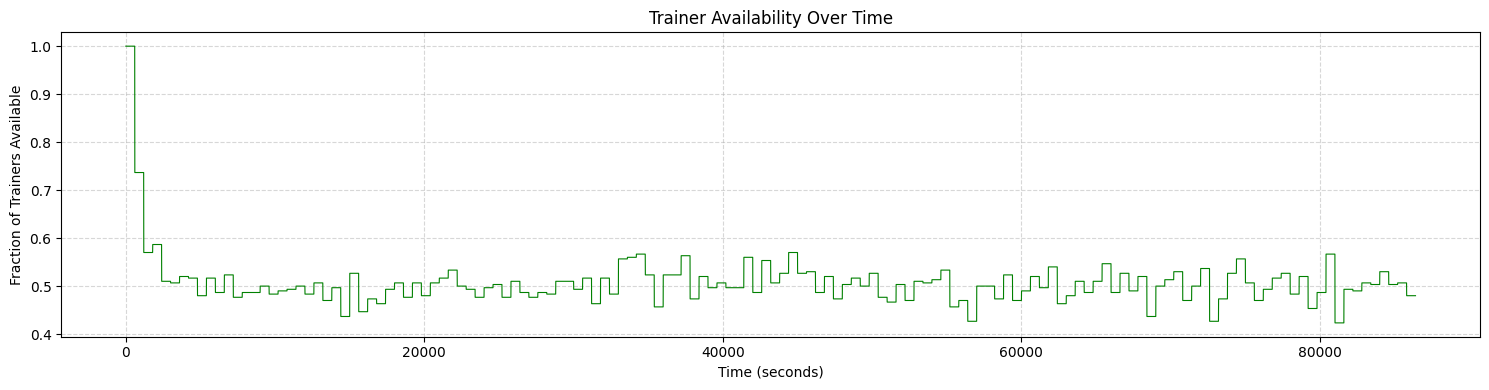

In [78]:
plot_availability_timeline(timestamps_combined)

In [ ]:
### Write 50% trainer avail configs to json files
dir_path = f"../../async_cifar10/trainer/config_dir0.1_num300_traceFail_6d_3state_oort/"

for file_name, timestamps in timestamps_combined.items():
    file_path = os.path.join(dir_path, file_name)
    
    # Check if the file exists
    if os.path.exists(file_path):
        with open(file_path, "r") as f:
            data = json.load(f)
        
        # Update the field inside hyperparameters
        if "hyperparameters" in data:
            data["hyperparameters"]["avl_events_syn_50"] = str(timestamps)
        
        # Save the updated JSON file
        with open(file_path, "w") as f:
            json.dump(data, f, indent=4)
    else:
        print(f"File {file_name} not found!")

In [80]:
## Delete 40% avail trainer configs from json files
dir_path = "../../async_cifar10/trainer/config_dir0.1_num300_traceFail_6d_3state_oort/"

for file_name, timestamps in timestamps_combined.items():
    file_path = os.path.join(dir_path, file_name)
    
    # Check if the file exists
    if os.path.exists(file_path):
        with open(file_path, "r") as f:
            data = json.load(f)
        
        # Remove the unwanted field if it exists
        if "hyperparameters" in data and "avl_events_syn_40" in data["hyperparameters"]:
            del data["hyperparameters"]["avl_events_syn_40"]

        # Save the updated JSON file
        with open(file_path, "w") as f:
            json.dump(data, f, indent=4)
    else:
        print(f"File {file_name} not found!")

## OLD CODE

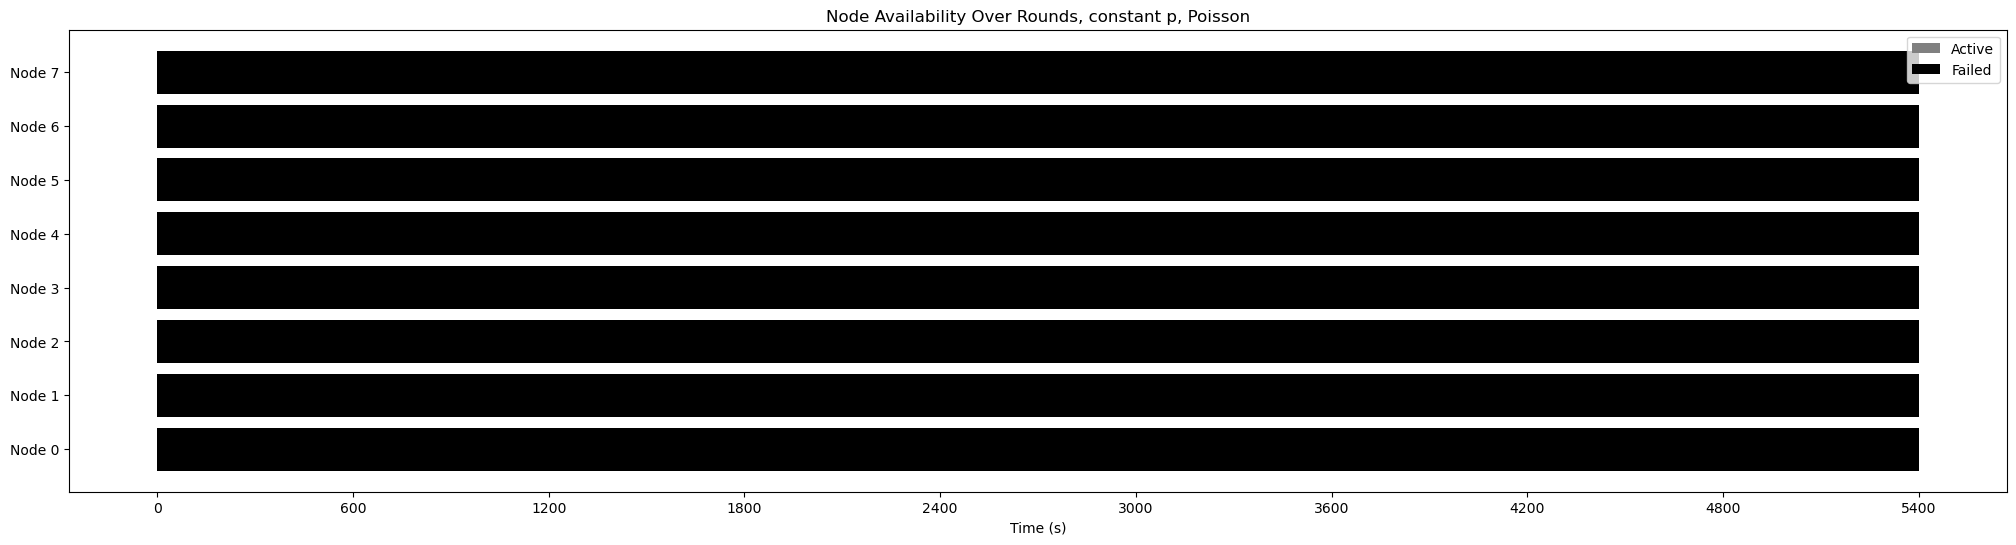

In [199]:
fig, ax = plt.subplots(figsize=(25, 6))

for node_num in range(num_nodes):
    availability = availability_array[:, node_num]
    ax.broken_barh([(i*600, 600) for i, val in enumerate(availability) if val == 0], (node_num - 0.4, 0.8), facecolors='grey')#, edgecolors='black', alpha=0.7)
    ax.broken_barh([(i*600, 600) for i, val in enumerate(availability) if val > 0], (node_num - 0.4, 0.8), facecolors='black')#, edgecolors='black', alpha=0.7)

ax.set_yticks(np.arange(num_nodes))
ax.set_yticklabels([f'Node {i}' for i in range(num_nodes)])
ax.set_xticks(np.arange((total_duration+1))*600)
ax.set_xlabel('Time (s)')
ax.set_title('Node Availability Over Rounds, constant p, Poisson')
ax.legend(['Active', 'Failed'])
plt.savefig('lambda-0.3-10min.png')
plt.show()

In [ ]:
dir_path = f"../lib/python/examples/async_cifar10/trainer/config_dir10_num300_traceFail_6d_3state_oort/"

for file_name, timestamps in timestamps_combined.items():
    file_path = os.path.join(dir_path, file_name)
    
    # Check if the file exists
    if os.path.exists(file_path):
        with open(file_path, "r") as f:
            data = json.load(f)
        
        # Update the field inside hyperparameters
        if "hyperparameters" in data:
            data["hyperparameters"]["avl_events_syn_40"] = str(timestamps)
        
        # Save the updated JSON file
        with open(file_path, "w") as f:
            json.dump(data, f, indent=4)
    else:
        print(f"File {file_name} not found!")

In [12]:
lambda_param = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8 ,1.9, 2.0]
num_rounds = 20
num_nodes = 10
availability_history = []

for i in range(num_rounds):
    round_availability = simulate_round(lambda_param[i],10)
    availability_history.append(round_availability)

availability_array = np.array(availability_history)

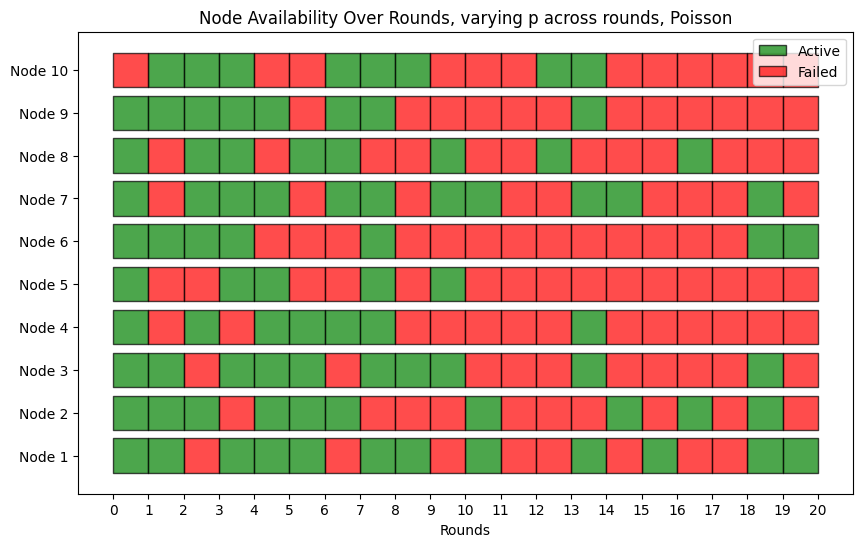

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

for node_num in range(num_nodes):
    availability = availability_array[:, node_num]
    ax.broken_barh([(i, 1) for i, val in enumerate(availability) if val == 0], (node_num - 0.4, 0.8), facecolors='green', edgecolors='black', alpha=0.7)
    ax.broken_barh([(i, 1) for i, val in enumerate(availability) if val > 0], (node_num - 0.4, 0.8), facecolors='red', edgecolors='black', alpha=0.7)

ax.set_yticks(np.arange(num_nodes))
ax.set_yticklabels([f'Node {i+1}' for i in range(num_nodes)])
ax.set_xticks(np.arange(num_rounds+1))
ax.set_xlabel('Rounds')
ax.set_title('Node Availability Over Rounds, varying p across rounds, Poisson')
ax.legend(['Active', 'Failed'])
plt.show()

In [14]:
lambda_param = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
num_rounds = 20
num_nodes = 10
availability_history = []

for i in range(num_nodes):
    round_availability = simulate_round(lambda_param[i],20)
    availability_history.append(round_availability)

availability_array = np.array(availability_history)

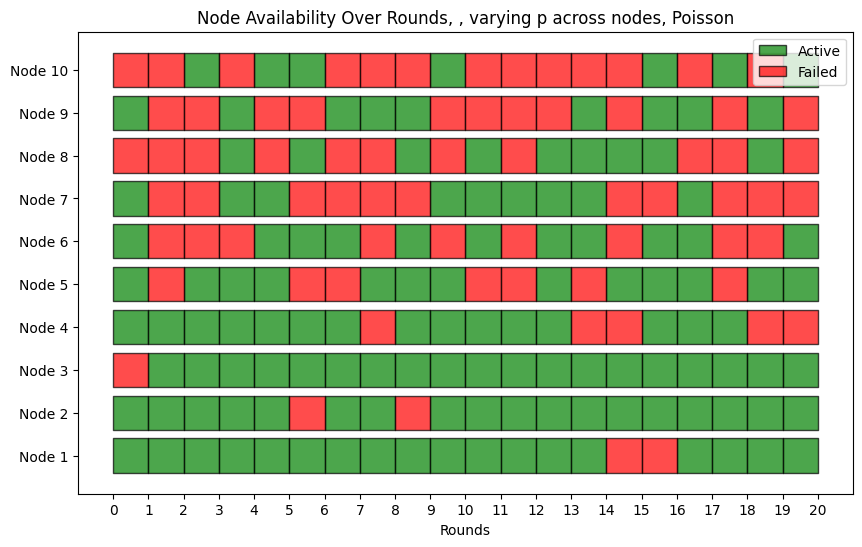

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

for node_num in range(num_nodes):
    availability = availability_array[node_num, :]
    ax.broken_barh([(i, 1) for i, val in enumerate(availability) if val == 0], (node_num - 0.4, 0.8), facecolors='green', edgecolors='black', alpha=0.7)
    ax.broken_barh([(i, 1) for i, val in enumerate(availability) if val > 0], (node_num - 0.4, 0.8), facecolors='red', edgecolors='black', alpha=0.7)

ax.set_yticks(np.arange(num_nodes))
ax.set_yticklabels([f'Node {i+1}' for i in range(num_nodes)])
ax.set_xticks(np.arange(num_rounds+1))
ax.set_xlabel('Rounds')
ax.set_title('Node Availability Over Rounds, , varying p across nodes, Poisson')
ax.legend(['Active', 'Failed'])
plt.show()

In [10]:
lambda_param = np.arange(0.1, 10.05, 0.05)
num_rounds = 20
num_nodes = 10
availability_history = []

for i in range(num_rounds):
    this_round = []
    for j in range(num_nodes):
        round_availability = simulate_round(lambda_param[10*i+j-1],1)
        this_round.append(round_availability)
    
    availability_history.append(this_round)

availability_array = np.array(availability_history)

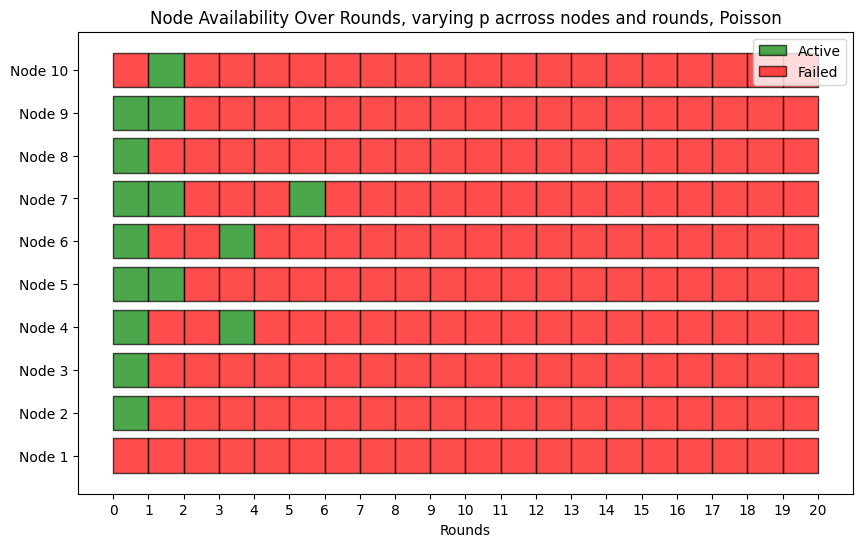

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

for node_num in range(num_nodes):
    availability = availability_array[:, node_num]
    ax.broken_barh([(i, 1) for i, val in enumerate(availability) if val == 0], (node_num - 0.4, 0.8), facecolors='green', edgecolors='black', alpha=0.7)
    ax.broken_barh([(i, 1) for i, val in enumerate(availability) if val > 0], (node_num - 0.4, 0.8), facecolors='red', edgecolors='black', alpha=0.7)

ax.set_yticks(np.arange(num_nodes))
ax.set_yticklabels([f'Node {i+1}' for i in range(num_nodes)])
ax.set_xticks(np.arange(num_rounds+1))
ax.set_xlabel('Rounds')
ax.set_title('Node Availability Over Rounds, varying p acrross nodes and rounds, Poisson')
ax.legend(['Active', 'Failed'])
plt.show()

In [12]:
np.random.binomial(1, 0.5, 10)

array([1, 0, 0, 0, 1, 1, 0, 0, 0, 0])

In [13]:
def simulate_round(probability, num_nodes):
    return np.random.binomial(1, probability, size=num_nodes)

In [26]:
lambda_param = 0.1 
num_rounds = 20
num_nodes = 10
availability_history = []

In [27]:
for _ in range(num_rounds):
    round_availability = simulate_round(lambda_param, 10)
    availability_history.append(round_availability)

availability_array = np.array(availability_history)

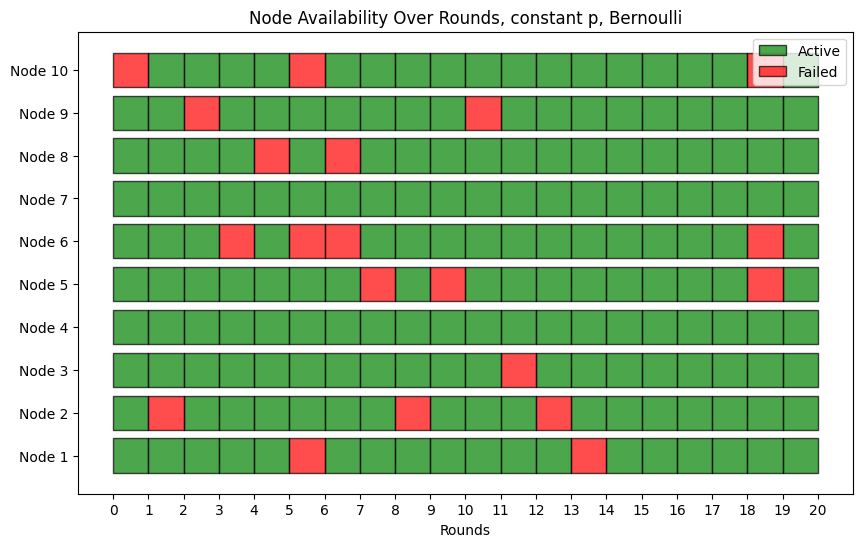

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))

for node_num in range(num_nodes):
    availability = availability_array[:, node_num]
    ax.broken_barh([(i, 1) for i, val in enumerate(availability) if val == 0], (node_num - 0.4, 0.8), facecolors='green', edgecolors='black', alpha=0.7)
    ax.broken_barh([(i, 1) for i, val in enumerate(availability) if val > 0], (node_num - 0.4, 0.8), facecolors='red', edgecolors='black', alpha=0.7)

ax.set_yticks(np.arange(num_nodes))
ax.set_yticklabels([f'Node {i+1}' for i in range(num_nodes)])
ax.set_xticks(np.arange(num_rounds+1))
ax.set_xlabel('Rounds')
ax.set_title('Node Availability Over Rounds, constant p, Bernoulli')
ax.legend(['Active', 'Failed'])
plt.show()

In [17]:
lambda_param = np.arange(0.05, 1.05, 0.05)
num_rounds = 20
num_nodes = 10
availability_history = []

for i in range(num_rounds):
    round_availability = simulate_round(lambda_param[i],10)
    availability_history.append(round_availability)

availability_array = np.array(availability_history)

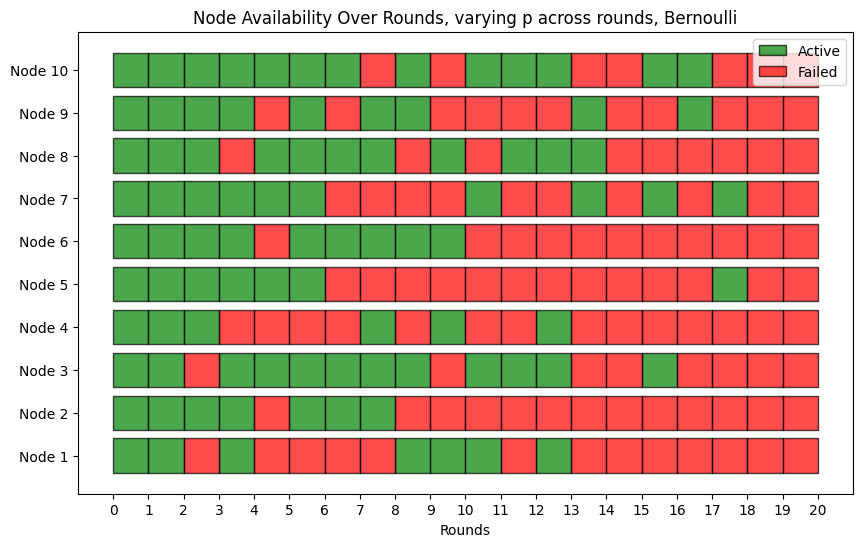

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

for node_num in range(num_nodes):
    availability = availability_array[:, node_num]
    ax.broken_barh([(i, 1) for i, val in enumerate(availability) if val == 0], (node_num - 0.4, 0.8), facecolors='green', edgecolors='black', alpha=0.7)
    ax.broken_barh([(i, 1) for i, val in enumerate(availability) if val > 0], (node_num - 0.4, 0.8), facecolors='red', edgecolors='black', alpha=0.7)

ax.set_yticks(np.arange(num_nodes))
ax.set_yticklabels([f'Node {i+1}' for i in range(num_nodes)])
ax.set_xticks(np.arange(num_rounds+1))
ax.set_xlabel('Rounds')
ax.set_title('Node Availability Over Rounds, varying p across rounds, Bernoulli')
ax.legend(['Active', 'Failed'])
plt.show()

In [19]:
lambda_param = np.arange(0.1,1.1,0.1)
num_rounds = 20
num_nodes = 10
availability_history = []

for i in range(num_nodes):
    round_availability = simulate_round(lambda_param[i],20)
    availability_history.append(round_availability)

availability_array = np.array(availability_history)

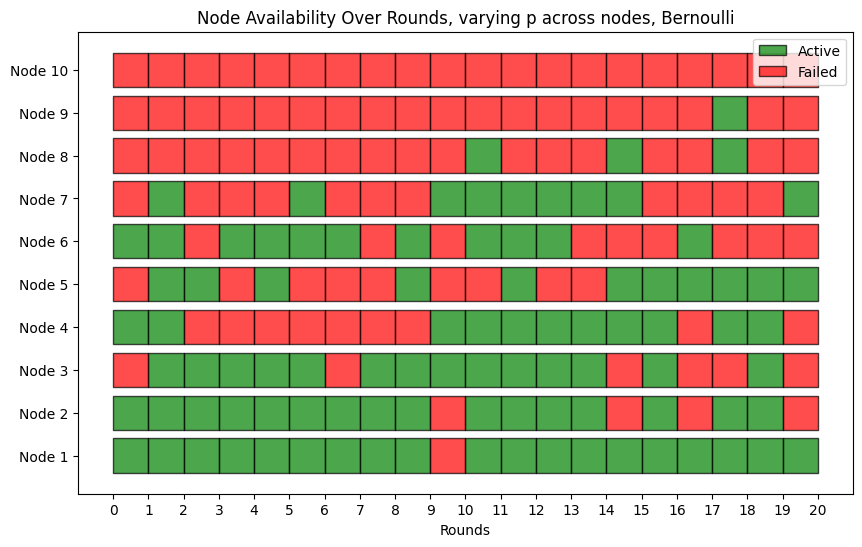

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))

for node_num in range(num_nodes):
    availability = availability_array[node_num, :]
    ax.broken_barh([(i, 1) for i, val in enumerate(availability) if val == 0], (node_num - 0.4, 0.8), facecolors='green', edgecolors='black', alpha=0.7)
    ax.broken_barh([(i, 1) for i, val in enumerate(availability) if val > 0], (node_num - 0.4, 0.8), facecolors='red', edgecolors='black', alpha=0.7)

ax.set_yticks(np.arange(num_nodes))
ax.set_yticklabels([f'Node {i+1}' for i in range(num_nodes)])
ax.set_xticks(np.arange(num_rounds+1))
ax.set_xlabel('Rounds')
ax.set_title('Node Availability Over Rounds, varying p across nodes, Bernoulli')
ax.legend(['Active', 'Failed'])
plt.show()

In [21]:
lambda_param = np.arange(0.005, 1.005, 0.005)
num_rounds = 20
num_nodes = 10
availability_history = []

for i in range(num_rounds):
    this_round = []
    for j in range(num_nodes):
        round_availability = simulate_round(lambda_param[10*i+j-1],1)
        this_round.append(round_availability)
    
    availability_history.append(this_round)

availability_array = np.array(availability_history)

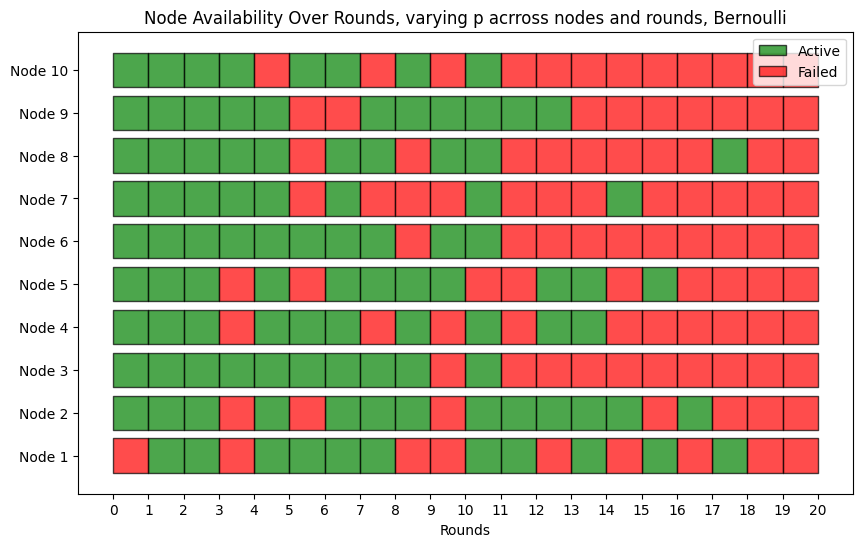

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))

for node_num in range(num_nodes):
    availability = availability_array[:, node_num]
    ax.broken_barh([(i, 1) for i, val in enumerate(availability) if val == 0], (node_num - 0.4, 0.8), facecolors='green', edgecolors='black', alpha=0.7)
    ax.broken_barh([(i, 1) for i, val in enumerate(availability) if val > 0], (node_num - 0.4, 0.8), facecolors='red', edgecolors='black', alpha=0.7)

ax.set_yticks(np.arange(num_nodes))
ax.set_yticklabels([f'Node {i+1}' for i in range(num_nodes)])
ax.set_xticks(np.arange(num_rounds+1))
ax.set_xlabel('Rounds')
ax.set_title('Node Availability Over Rounds, varying p acrross nodes and rounds, Bernoulli')
ax.legend(['Active', 'Failed'])
plt.show()

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms

In [9]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 50000

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [15]:
class_dict = {}
for _,label in trainloader:
    for i in range(len(label)):
        if f"trainer_{label[i].item()+1}.json" not in class_dict:
            class_dict[f"trainer_{label[i].item()+1}.json"] = [i]
        else:
            class_dict[f"trainer_{label[i].item()+1}.json"].append(i)

In [19]:
dir_path = f"../lib/python/examples/async_cifar10/trainer/config16/"

for file_name, indices in class_dict.items():
    file_path = os.path.join(dir_path, file_name)
    
    # Check if the file exists
    if os.path.exists(file_path):
        with open(file_path, "r") as f:
            data = json.load(f)
        
        # Update the field inside hyperparameters
        if "hyperparameters" in data:
            data["hyperparameters"]["trainer_indices_list"] = indices
        
        # Save the updated JSON file
        with open(file_path, "w") as f:
            json.dump(data, f, indent=4)
    else:
        print(f"File {file_name} not found!")